# MovieLens

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time

## load data

In [26]:
data = pd.read_csv("data/data.txt", sep="\t", header=None,
                   names=["user", "movie", "rating"])
movies = pd.read_csv("data/movies.txt", sep="\t", header=None, index_col=0,
                     names=["movie","title","unknown","action","adventure","animation",
                            "childrens", "comedy","crime","documentary","drama",
                            "fantasy", "filmnoir", "horror","musical","mystery",
                            "romance","scifi","thriller","war","western"]
                    )

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

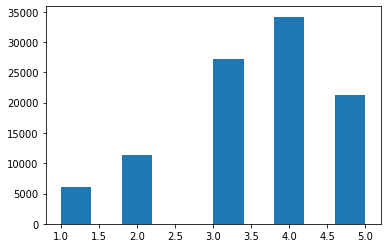

In [28]:
plt.hist(data["rating"])

## SVD

In [2]:
def grad_U(Ui, Yij, Vj, reg):
    """
    Returns the gradient of the regularized loss function with
    respect to Ui.
    """
    return reg * Ui - Vj * (Yij - np.dot(Ui, Vj))

def grad_V(Vj, Yij, Ui, reg):
    """
    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return reg * Vj - Ui * (Yij - np.dot(Ui, Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # regularization term
    r = .5 * reg * (np.sum(np.square(U)) + np.sum(np.square(V))) if reg else 0
    # add error term and divide by number of data points
    return (r + .5 * np.sum(np.square(
                # calculates reconstruction error
                Y[:,2] - np.einsum("ij,ij->i",
                          U[Y[:,0]-1,], # one-indexed users and movies
                          V[Y[:,1]-1,]
                )
            ))) / len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    eprev = get_err(U, V, Y)
    reduction0 = 1
    for epoch in range(max_epochs):
        for i in np.random.permutation(len(Y)):
            user, movie, rating = Y[i,0]-1, Y[i,1]-1, Y[i,2]
            # calculate gradients at once
            gU = grad_U(U[user], rating, V[movie], reg, eta)
            gV = grad_V(V[movie], rating, U[user], reg, eta)
            # before descending
            U[user] -= eta * gU
            V[movie] -= eta * gV
        e = get_err(U, V, Y, reg=reg)
        # stopping conditions
        reduction = eprev - e
        reductionratio = reduction / reduction0
        #print("epoch", epoch, eprev, reductionratio)
        if (epoch == 0):
            reduction0 = reduction
        if (reductionratio < eps):
            break
        eprev = e
    print("trained epochs:", epoch, reduction)
    return U, V, e

## 2D:
Run the cell below to get your graphs

Factorizing with  943  users,  1682  movies.
K 10
trained epochs: 17 0.0003561911339897694
K 20
trained epochs: 27 0.00048734124876081975
K 30
trained epochs: 24 0.0004659912529364624
K 50
trained epochs: 23 -3.9355490590177455e-05
K 100
trained epochs: 17 0.00035754578734423616
elapsed 160.91393899917603


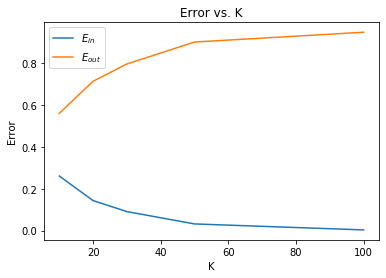

In [3]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = [10,20,30,50,100]

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
start = time.time()
for K in Ks:
    print("K", K)
    U,V, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    E_out.append(get_err(U, V, Y_test))
print("elapsed", time.time() - start)

plt.plot(Ks, E_in, label='$E_{in}$')
plt.plot(Ks, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2d.png')

## 2E:
Run the cell below to get your graphs. This might take a long time to run, but it should take less than 2 hours. I would encourage you to validate your 2C is correct.

Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 0.0001
trained epochs: 13 -0.00030569675098157667
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001
trained epochs: 16 -0.0009414571753399714
Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 0.0001
trained epochs: 23 0.0001965457208405741
Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 0.0001
trained epochs: 22 0.0006177478195454542
Training model with M = 943, N = 1682, k = 100, eta = 0.03, reg = 0.0001
trained epochs: 17 0.0006229772654864404
Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 0.001
trained epochs: 17 -0.0013958983590586782
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.001
trained epochs: 21 0.00029990712932975727
Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 0.001
trained epochs: 18 0.0005439426496856165
Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 0.001
trained epochs: 27 0.0

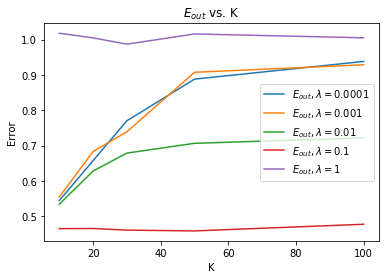

In [4]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
Ks = [10,20,30,50,100]

regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
eta = 0.03 # learning rate
E_ins = []
E_outs = []

# Use to compute Ein and Eout
start = time.time()
for reg in regs:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    for k in Ks:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
        U,V, e_in = train_model(M, N, k, eta, reg, Y_train)
        E_ins_for_lambda.append(e_in)
        eout = get_err(U, V, Y_test)
        E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)
print("elapsed", time.time() - start)

# Plot values of E_in across k for each value of lambda
for i in range(len(regs)):
    plt.plot(Ks, E_ins[i], label='$E_{in}, \lambda=$'+str(regs[i]))
plt.title('$E_{in}$ vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2e_ein.png')	
plt.clf()

# Plot values of E_out across k for each value of lambda
for i in range(len(regs)):
    plt.plot(Ks, E_outs[i], label='$E_{out}, \lambda=$'+str(regs[i]))
plt.title('$E_{out}$ vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()	
plt.savefig('2e_eout.png')		
